# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [52]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 30
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

# Initialize stim circuit

In [53]:
# AFTER_CLIFFORD_DEPOLARIZATION = 0.8e-3
# AFTER_RESET_FLIP_PROBABILITY = 0.1e-2
# BEFORE_MEASURE_FLIP_PROBABILITY = 0.5e-2 
# BEFORE_ROUND_DATA_DEPOLARIZATION = 0.8e-2

# Good error rate _resets = True
AFTER_CLIFFORD_DEPOLARIZATION = 3e-2
AFTER_RESET_FLIP_PROBABILITY = 0.8e-2
BEFORE_MEASURE_FLIP_PROBABILITY = 1e-2 
BEFORE_ROUND_DATA_DEPOLARIZATION = 3e-2

# AFTER_CLIFFORD_DEPOLARIZATION = 6e-2
# AFTER_RESET_FLIP_PROBABILITY = 1.6e-2
# BEFORE_MEASURE_FLIP_PROBABILITY = 2e-2 
# BEFORE_ROUND_DATA_DEPOLARIZATION = 6e-2


SHOTS = int(1e3)

In [54]:
import stim
stim_circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=AFTER_CLIFFORD_DEPOLARIZATION, #two-qubit-fidelity,
                                after_reset_flip_probability=AFTER_RESET_FLIP_PROBABILITY, #reset error,
                                before_measure_flip_probability=BEFORE_MEASURE_FLIP_PROBABILITY, #measurement error,
                                before_round_data_depolarization=BEFORE_ROUND_DATA_DEPOLARIZATION) #idle error)



meas_outcomes = stim_circuit.compile_sampler().sample(SHOTS)
counts = {}
for row in meas_outcomes:
    count_str = ''
    for nb, bit in enumerate(row):
        count_str += '0' if bit == False else '1'
        if (nb+1) % (DISTANCE-1) == 0 and nb < ROUNDS*(DISTANCE-1):
            count_str += ' ' 
    count_str = count_str[::-1]
    if count_str in counts:
        counts[count_str] += 1
    else:
        counts[count_str] = 1
print(counts)

{'1111000 000100 100111 100000 100100 100100 010100 010100 010100 010100 010111 010111 010110 010111 000011 010111 010111 010110 010100 010100 010100 010110 001110 001011 001111 001111 001110 001100 000000 000000 000000': 1, '0001110 000001 101001 000001 000010 000110 000110 000110 000010 011000 011000 011000 011110 011110 011110 011110 011110 011110 001110 011000 001000 101001 111001 111001 111000 111001 101001 100001 100001 000000 000000': 1, '0111011 101110 100110 000100 001110 000110 000110 000101 010101 011101 011101 010001 100001 100001 100011 100001 100001 000001 000001 000001 000001 000001 000001 000001 000001 000001 000001 000001 000001 000001 000000': 1, '1110100 001110 001100 101110 101110 101110 101110 101110 101110 101110 101111 101111 101010 110000 001000 101000 101011 011011 011011 010011 011011 010011 011011 011011 001011 000111 000011 000011 011011 001011 000000': 1, '1001101 101011 101011 101011 101011 101011 111011 110011 110011 110100 110101 110000 110101 110101 110

In [55]:
# not correct if we look at the count string!
verbose = False

no_reset_counts = {}
for count_key, shots in counts.items():
    parts=count_key.split(" ")
    print("parts:", parts) if verbose else None
    count_part = parts[0]
    print("count_part:", count_part) if verbose else None  
    check_parts = parts[1:]
    print("check_parts:", check_parts, "\n") if verbose else None

    for i in range(len(check_parts)):
        if i == 0:
            print("skipped last check part:", check_parts[-1], "\n") if verbose else None
            continue
        current_check_str = check_parts[-(i+1)]
        print("current_check_str:", current_check_str) if verbose else None
        prev_check_str = check_parts[-i]
        print("prev_check_str:", prev_check_str) if verbose else None
        new_check_str = ''
        for bit1, bit2 in zip(prev_check_str, current_check_str):
            new_check_str += str(int(bit1)^int(bit2))
        print("new_check_str:", new_check_str, "\n") if verbose else None
        check_parts[-(i+1)] = new_check_str

    print("\ncheck_parts after modulo:", check_parts) if verbose else None

    new_count_str = count_part + " " +  ' '.join(check_parts)
    print("\nnew_count_str:", new_count_str) if verbose else None

    
    if new_count_str in no_reset_counts:
        no_reset_counts[new_count_str] += shots
    else:
        no_reset_counts[new_count_str] = shots

if _RESETS is False:
    print("Taking no reset counts")
    counts = no_reset_counts
else: 
    print("Taking reset counts")

print(counts)

Taking no reset counts
{'1111000 010010 010110 110001 010001 110101 010001 000101 010001 000101 010001 000110 010001 000111 010000 010011 000100 010011 000101 010001 000101 010001 000111 001001 000010 001101 000010 001100 000000 000000 000000': 1, '0001110 101000 101001 000000 000001 000011 000101 000011 000101 000111 011111 000111 011111 000001 011111 000001 011111 000001 011111 010001 001001 000001 101000 010001 101000 010000 101001 000000 100001 000000 000000': 1, '0111011 100001 001111 101001 101101 100011 100101 100011 100110 110011 101110 110011 100010 000011 100010 000001 100000 000001 000000 000001 000000 000001 000000 000001 000000 000001 000000 000001 000000 000001 000000': 1, '1110100 111010 110100 111000 010110 111000 010110 111000 010110 111000 010110 111001 010110 111100 001100 000100 101100 000111 011100 000111 010100 001111 011100 000111 011100 010111 010000 010011 010000 001011 000000': 1, '1001101 001010 100001 001010 100001 001010 100001 011010 101001 011010 101110 0

In [56]:
IQ_data = simulator.counts_to_IQ(counts)

100%|██████████| 1000/1000 [00:00<00:00, 11881.54it/s]


# Get counts from IQ data

In [57]:
import cpp_soft_info

print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'0000000 000000 000000 001100 000010 001010 001110 001110 001111 101111 001111 101111 001111 101111 001111 101001 001111 001001 001111 000001 001111 001001 001111 001001 001111 001001 001110 000000 000000 100000 000000': 1, '0000000 000000 101100 100100 101000 100100 101000 100101 101000 101100 101100 101100 101100 101100 011100 011100 011100 011100 010000 101100 110000 111100 110000 011100 110000 110000 110000 100000 100000 100000 000000': 1, '0000000 001001 011001 011011 001011 001001 001011 001001 011001 011000 011001 011100 101011 011100 111011 010100 011011 011011 111011 011011 111000 011011 111100 011111 111100 111111 011100 110111 000010 000001 000000': 1, '0000000 010111 010111 010110 010101 010001 010101 011001 010010 011001 010010 011001 010010 011001 010010 000101 000110 001101 000110 001101 000110 001101 000110 001101 000010 001111 000010 001111 000010 001100 000000': 1, '0000000 011111 011111 011011 011101 011011 000101 111011 000101 101011 001001 100011 001001 110011 100

# Decode IQ data

In [58]:
import pymatching
import stim

model = stim_circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [59]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True,
                                            p_offset = 1, p_multiplicator = 1)
print("num_errors:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

num_errors: 79 out of 1000 shots for _RESETS = False


In [63]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = -1
# p_meas = 20e-2 


result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors: 103 out of 1000 shots for _RESETS = False


In [61]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)


num_errors: 126 out of 1000 shots for _RESETS = False


# Plot the results

In [64]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [10, 32, 49, 65, 96, 100, 120, 123, 132, 134, 168, 182, 189, 196, 218, 244, 277, 281, 283, 302, 307, 308, 351, 356, 360, 399, 431, 454, 479, 494, 502, 514, 529, 550, 553, 560, 561, 564, 569, 570, 581, 592, 593, 596, 609, 612, 623, 628, 629, 657, 670, 678, 684, 694, 696, 703, 707, 727, 750, 753, 771, 781, 794, 814, 833, 835, 862, 867, 872, 875, 880, 901, 908, 937, 947, 951, 953, 960, 991] 
Flat: [1, 4, 13, 20, 32, 38, 44, 51, 54, 56, 58, 65, 100, 120, 134, 138, 142, 158, 168, 171, 172, 182, 188, 189, 196, 212, 218, 225, 236, 252, 267, 277, 281, 283, 293, 302, 307, 308, 313, 317, 320, 338, 351, 359, 360, 399, 405, 421, 447, 451, 454, 458, 477, 479, 494, 502, 511, 514, 538, 550, 553, 561, 564, 569, 583, 592, 593, 596, 603, 609, 610, 612, 618, 623, 628, 629, 645, 657, 672, 674, 678, 684, 694, 702, 703, 741, 745, 750, 753, 765, 771, 775, 785, 791, 794, 796, 799, 800, 816, 818, 846, 855, 859, 865, 872, 875, 894, 897, 900, 907, 908, 931, 934, 937, 939, 947, 950, 951, 960, 965, 972, 977, 

-----IQ False decoding -----


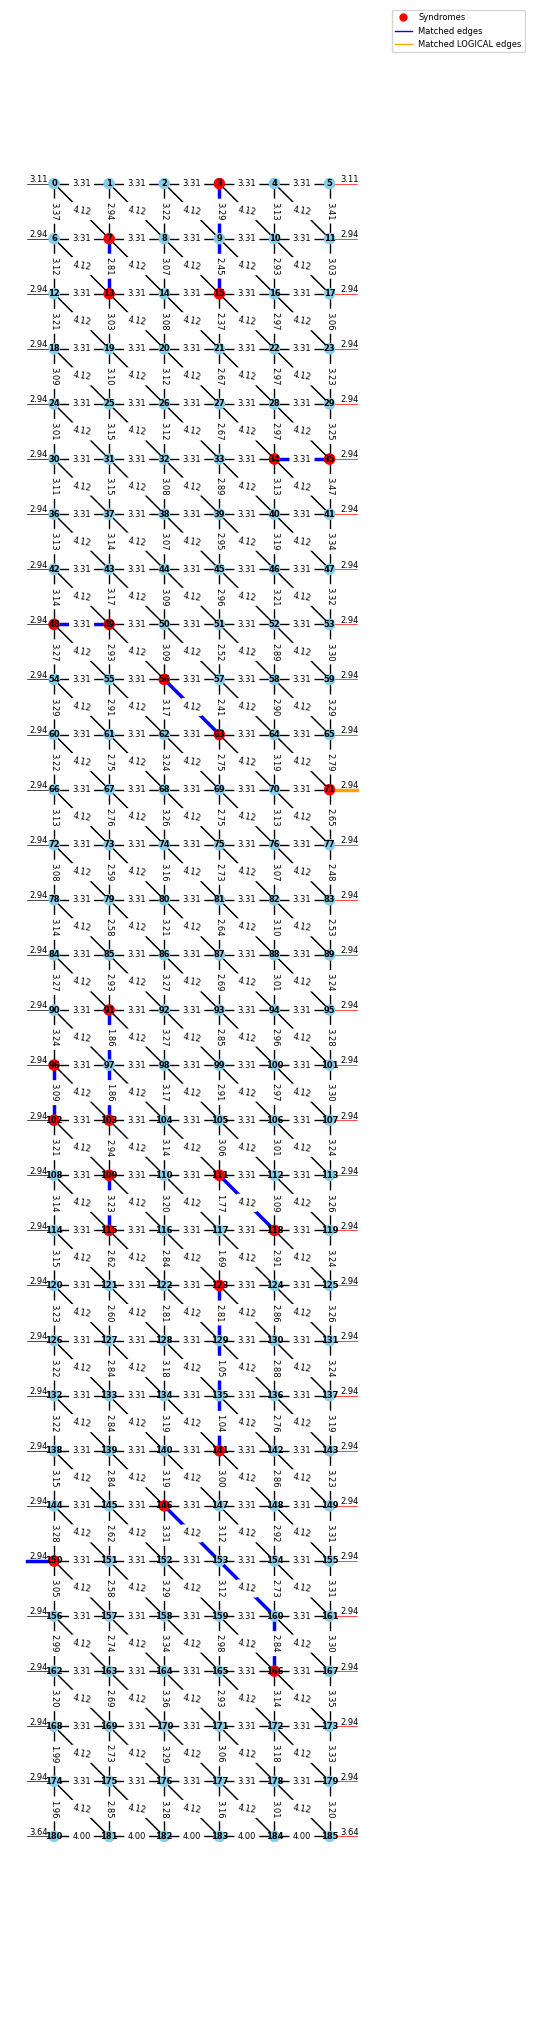

-----flat True decoding-----


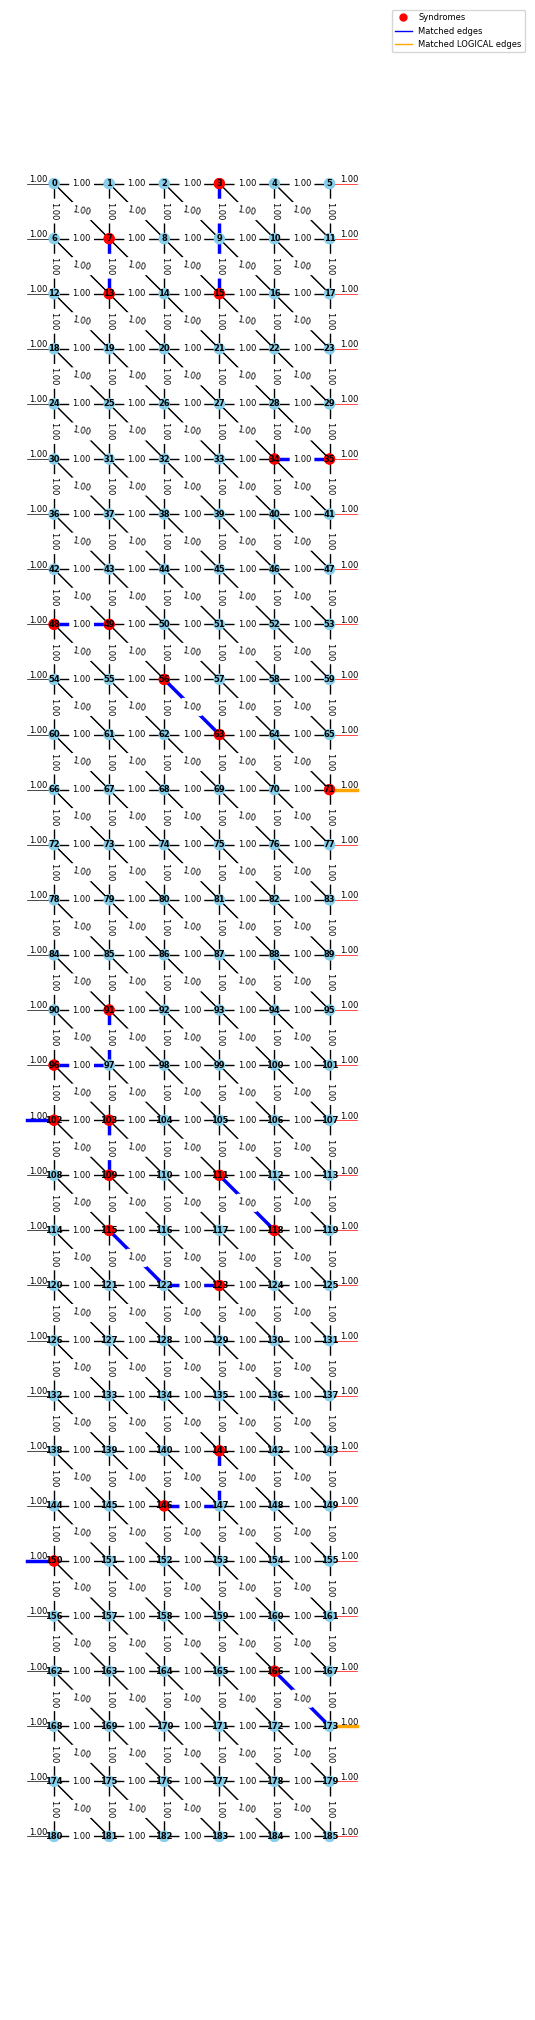

-----INFORMED True decoding-----


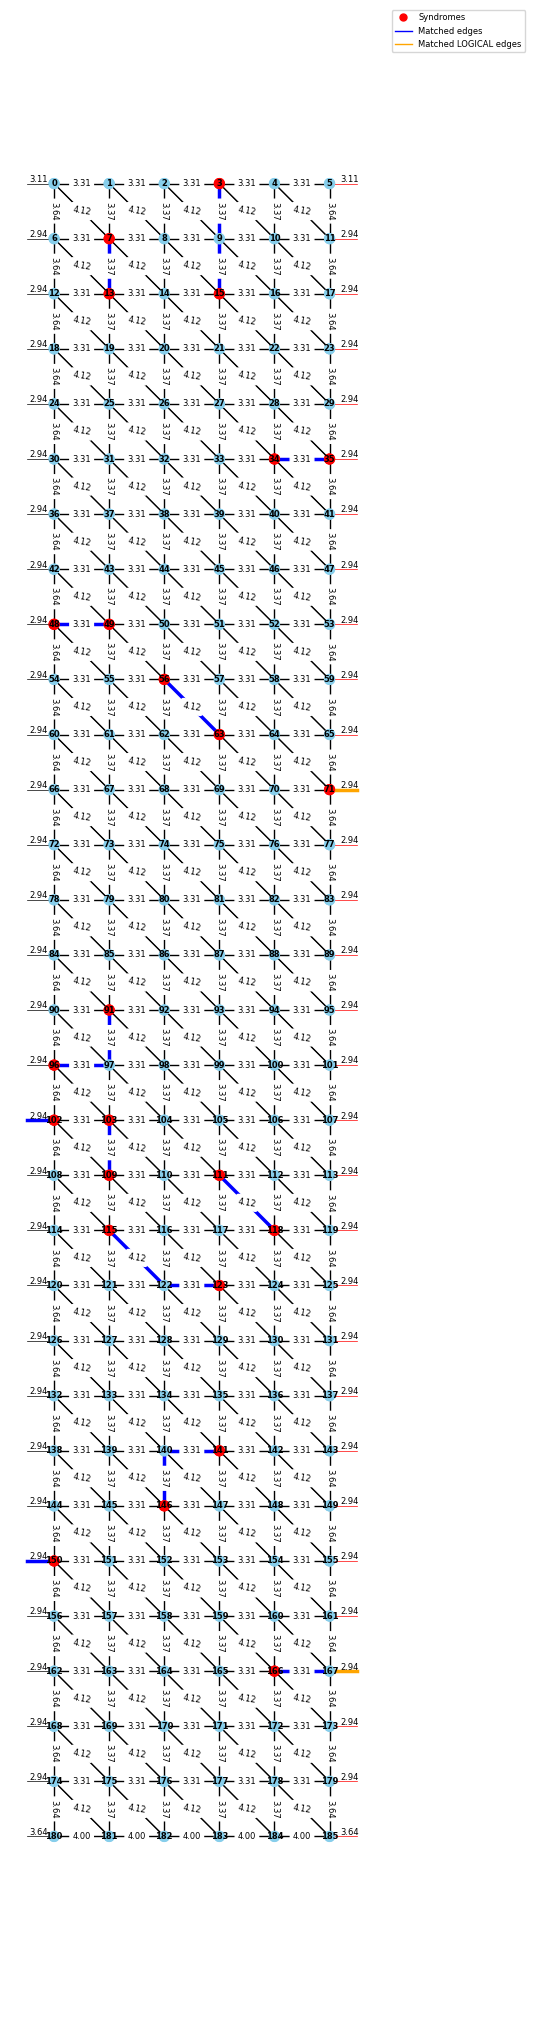

In [71]:
from soft_info import draw_matching_graph


index = 10

# fig_size = (4, 13)
fig_size = (20, 20)
scale_factor = 0.5

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----IQ {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----flat {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print(f"-----INFORMED {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [73]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 45
[39, 44, 56, 138, 171, 188, 225, 252, 293, 320, 331, 348, 359, 376, 400, 405, 447, 451, 469, 477, 506, 583, 618, 619, 630, 741, 745, 761, 768, 770, 791, 799, 816, 817, 831, 855, 858, 864, 902, 931, 934, 966, 971, 972, 977]
indices that are in IQ but not in informed with len: 21
[10, 123, 132, 218, 244, 308, 502, 529, 553, 560, 564, 581, 703, 727, 814, 833, 862, 880, 901, 937, 953]

indices that are in IQ but not in flat with len: 25
[10, 49, 96, 123, 132, 244, 356, 431, 529, 560, 570, 581, 670, 696, 707, 727, 781, 814, 833, 835, 862, 867, 880, 901, 953]
indices that are in flat but not in IQ with len: 72
[1, 4, 13, 20, 38, 44, 51, 54, 56, 58, 138, 142, 158, 171, 172, 188, 212, 225, 236, 252, 267, 293, 313, 317, 320, 338, 359, 405, 421, 447, 451, 458, 477, 511, 538, 583, 603, 610, 618, 645, 672, 674, 702, 741, 745, 765, 775, 785, 791, 796, 799, 800, 816, 818, 846, 855, 859, 865, 894, 897, 900, 907, 931, 934, 939, 950, 965, 972, 977

# Analyse specific shots

In [74]:
from tqdm import tqdm

index = 64
IQ_data = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print("-----IQ-----")
# draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        # matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

{'1001000 110000 011100 110000 010100 101110 010110 101110 000110 101110 010110 101111 001110 001011 000010 000011 000010 000011 000001 000001 000000 000001 001000 001000 001000 001000 001000 001000 001000 001000 001000': 1}


100%|██████████| 547/547 [00:00<00:00, 2907838.13it/s]

mean time edge weight: 2.916971160637008
-----IQ-----
